# Study 1. Exploring the taxonomic diversification within ecoregions.

Study 1
=======

This is the first analysis on the series: *Studies on Biodiversity*.
This study explores the intrinsic properties of the changes (ratios) from different
taxonomic levels at the highest resolution grid. 
Each cell has a defined taxonomy object and, as seen before, each taxonomy has a taxonomic tree associated.
The information is converted to a 7x7 Matrix that relates the ratios between the different taxonomic levels.
For example, the entry 2,1 is the ratio between the *genus* and the *specie* level.

The study selects the polygons for a given eco-region type and filter the Taxonomies that are true under the operation of *intersection* and *within*.
For each of these subsets the mean and standard deviation matrix is calculated to characterize the average and variation of the intrinsic properties in every ecoregion. 

This process is made for all ecoregions' type and the results are shown as graphs.



## Methods

In [3]:
def PanelizeMatrices(list_of_taxonomies):
    """
    ..
    Extracts the intrinsic matrices from the taxonomies given as parameters.
    
    Returns
    =======
        a Panel
            Similar to a matrix with the difference that each entry is a list.
            Each element of this list correspond to the entry of the intrinsic matrix 
        
    """
    all_entries = []
    for i in range(7):
        li = []
        for j in range(7):   
            i_j = map(lambda t : t.intrinsicM[i,j],list_of_taxonomies)
        li.append(pn.Series(i_j))
        all_entries.append(li)
    return all_entries
    

In [4]:
def PanelizeMatrices_dic(list_of_taxonomies):
    """
    ..
    Extracts the intrinsic matrices from the taxonomies given as parameters.
    
    Returns
    =======
        a Panel
            Similar to a matrix with the difference that each entry is a list.
            Each element of this list correspond to the entry of the intrinsic matrix 
        
    """
    all_entries = {}
    for i,tax_name_i in enumerate(settings.TAXONOMIC_TREE_KEYS):
        li = {}
        for j,tax_name_j in enumerate(settings.TAXONOMIC_TREE_KEYS):   
            i_j = map(lambda t : t.intrinsicM[i,j],list_of_taxonomies)
            li[tax_name_j] = pn.Series(i_j)
        all_entries[tax_name_i] = li
    return all_entries    



In [5]:
def getMeanStdfromPanel(panel):
    """
    ..
    Returns two dataframes Mean and Std in which  Mean is the average of the series for the i,j Serie
    Std is the standard deviation Matrix in which each entry is the std of the i,j serie.
    
    """
    mean = {}
    std = {}
    keys = ['sp','gns','fam','ord','cls','phy','kng']
    for i,key_i in enumerate(keys):
        means = {}
        stds = {}
        for j,key_j in enumerate(keys):
            means[str(j+1)+key_j] = panel[key_i][key_j].mean()
            stds[str(j+1)+key_j] = panel[key_i][key_j].std()
        mean[str(i+1)+key_i] = means
        std[str(i+1)+key_i] = stds
    return pn.DataFrame(mean),pn.DataFrame(std)

In [6]:
def getTaxonomiesPerEcoregion_dic(z_numbers,regions_polys_dic,list_taxonomies):
    """
    This method generate a dictionary for each ecoregion class (polygon) 
    with the taxonomies that:
    
    * Intersects with each polygon 
    * Are in the interior of each polygon (within)
    
    Parameters
    ==========
        
        z_numbers : list 
            The ordered list of ecoregion types
        regions_polys_dic : dictionary
            The dictionary that defines the class and the multipolygon object
        list_taxonomies : list
            The list of taxonomies that are going to be geoprocessed (filtered)
    
    
    Returns
    =======
    
        taxonomies_per_ecoregion : dictionary
            Complex structure with keys as ecoregion type and values as:
                regions : Multipolygon
                taxonomies_intersects : list of taxonomies that intersect each class
                taxonomies_within : list of taxonomies that are in the interior (within) of each polygon.
                
    """            

    taxonomies_per_ecoregion_mergpol = {}
    for i in z_numbers:
        poly = regions_polys_merged[int(i)]['polygon']
        tax_intersect = filter(lambda t : t.biomeGeometry.intersects(poly),list_taxonomies)
        tax_list_within = filter(lambda t : t.biomeGeometry.within(poly),list_taxonomies)
        monoid = {'polygons' : poly, 'taxonomies_intersect' : tax_intersect,'taxonomies_kernel':tax_list_within}
        taxonomies_per_ecoregion_mergpol[int(i)] = monoid
    return taxonomies_per_ecoregion_mergpol


## Methodology

### Selection of Study Area

The region of central-south Mexico shows an interesting representation of several Ecoregions. The study area has two coastlines. On the East the *Gulf of Mexico* and on the West the *Pacific Ocean*. Also, a altitudinal gradient from that ranges from 0 to 3000m above sea level. Three mountain chains, *Sierra Madre Oriental*, *Sierra Madre Occidental* and the volcanic chain *Eje Volcánico*. 

When overlaped with the GBIF occurrences it is clear that has a good amount of Occurrences (See figure below).
Therefore, the cell *36* from the grid ´mexico_grid8´ is a good candidate for generating the NestedTaxonomy. 

The figure below show the cell *36* with GBIF Occurrences and Ecoregions overlaped.

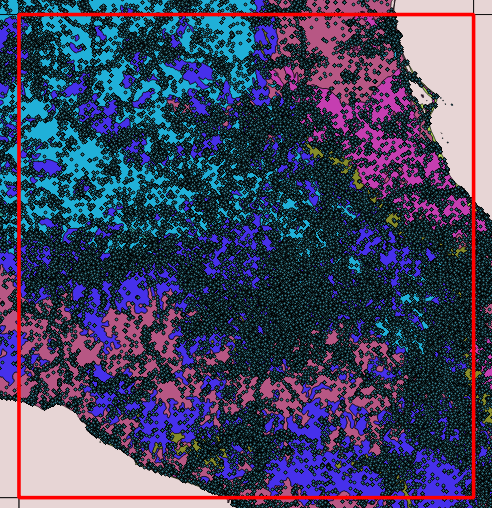

In [11]:
from IPython.display import Image
Image(filename='docs/_static/ecoregions_center.png')

In [1]:
#Import modules
from gbif.taxonomy import NestedTaxonomy
from gbif.models import Occurrence
from ecoregions.models import Ecoregion
from django.contrib.gis.db.models import Union, Min
import biospatial.settings as settings
import pandas as pn

No module named MySQLdb


 MySQLdb module could not be loaded


## Partitionate the *biosphere* in different Ecoregions

The Ecoregions map is defined in the Mexican territory. The amount of Occurrences spreaded in this region is huge (circa: 4 Millions).
For now on, this analysis will focus on the region bounded by the Cell 36 defined by the grid: `mexico_grid8`

**Summary**

Let $biosphere$ be the set of Occurrences in the surface of the Earth and $E_k$ the Ecoregions corresponding to the class $k$. Every $E_k$ is a compact set that has certain ecological properties, as explained before.

**Definition**

Let $bios_k$ the subset of GBIF occurrences given by the spatial relationship *intersect* or *interior* on the ecoregion $E_k$.

$bios_k \subset biosphere$ given by $\{ x \in biosphere \wedge x $ geometrically within/intersect the $E_k \}$



Let $biosphere$ be the set of all Occurrences in Earth from all times.

In [7]:
biosphere = Occurrence.objects.all()

$Biosphere$ has all the historic records. It is important to bound all the regions for a given time. The occurrences made in this study are going to be from the year 1970 onwards.


In [12]:
biosphere = biosphere.filter(year__gt=1970)

### Instantiate a Nested Taxonomy 

Let $nt$ be $Nested Taxonomy$ for the cell *36* up to the scale-level 10

In [13]:
nt = NestedTaxonomy(36,biosphere,start_level=3,end_level=10,generate_tree_now=False)

INFO [biospatial.gbif.taxonomy.embedTaxonomyinNestedGrid] Embeding local biomes in grid 
INFO:biospatial.gbif.taxonomy:[biospatial.gbif.taxonomy.embedTaxonomyinNestedGrid] Embeding local biomes in grid 
INFO [biospatial.gbif.taxonomy.embedTaxonomyinNestedGrid] Embeding local biomes in grid 
INFO:biospatial.gbif.taxonomy:[biospatial.gbif.taxonomy.embedTaxonomyinNestedGrid] Embeding local biomes in grid 
INFO [biospatial.gbif.taxonomy.embedTaxonomyinNestedGrid] Embeding local biomes in grid 
INFO:biospatial.gbif.taxonomy:[biospatial.gbif.taxonomy.embedTaxonomyinNestedGrid] Embeding local biomes in grid 
INFO [biospatial.gbif.taxonomy.embedTaxonomyinNestedGrid] Embeding local biomes in grid 
INFO:biospatial.gbif.taxonomy:[biospatial.gbif.taxonomy.embedTaxonomyinNestedGrid] Embeding local biomes in grid 
INFO [biospatial.gbif.taxonomy.embedTaxonomyinNestedGrid] Embeding local biomes in grid 
INFO:biospatial.gbif.taxonomy:[biospatial.gbif.taxonomy.embedTaxonomyinNestedGrid] Embeding local b

The geometry of the study area is defined by the boundary *biomeGeometry* of the top taxonomy (nt.parent).

* Let *study_area* be the geometric extension for this study. 

In [14]:
study_area = nt.parent.biomeGeometry


Select the *Ecoregions* that are defined in the interior of the study area.

In [15]:
ecoregions = Ecoregion.objects.all()
ecoregions_in_area = ecoregions.filter(geom__within=study_area)

The zone types are classified with an integer index. To obtain a set (without repetitions) let's do the following trick:

In [20]:
zonenumbers = list(set(map(lambda e : e.num_zona,ecoregions_in_area)))
print zonenumbers

[u'1', u'3', u'2', u'5', u'4', u'7', u'6', None]


Then, filtering the *None* object

In [21]:
z_numbers = filter(lambda x : x != None,zonenumbers)
print z_numbers

[u'1', u'3', u'2', u'5', u'4', u'7', u'6']


The total number of ecoregions in the study area is:

In [22]:
len(ecoregions_in_area)

222

The following ecoregions are scattered it is important to make an aggregation (Union)of these polygons by class type


In [23]:
from django.contrib.gis.db.models import Union, Min
regions_polys_merged = {}
for i in z_numbers:
    regions_polys_merged[int(i)]=ecoregions_in_area.filter(num_zona=int(i)).aggregate(polygon=Union('geom'),name=Min('nomzonecol'.encode('latin-1')),zone_id=Min('num_zona'))


$regionspolysmerged$ is a dictionary with keys $\in z numbers$ and values as $name$ and the polygon union.

In [24]:
print regions_polys_merged

{1: {'zone_id': u'1', 'name': u'Tropical h\xa3meda', 'polygon': <MultiPolygon object at 0x11e1ff370>}, 2: {'zone_id': u'2', 'name': u'Tropical subh\xa3meda', 'polygon': <MultiPolygon object at 0x11e1ff490>}, 3: {'zone_id': u'3', 'name': u'Templada h\xa3meda', 'polygon': <MultiPolygon object at 0x11e1ff400>}, 4: {'zone_id': u'4', 'name': u'Templada subh\xa3meda', 'polygon': <MultiPolygon object at 0x11e1ff5b0>}, 5: {'zone_id': u'5', 'name': u'\xb5rida y semi\xa0rida', 'polygon': <MultiPolygon object at 0x11e1ff520>}, 6: {'zone_id': u'6', 'name': u'Alpina', 'polygon': <MultiPolygon object at 0x11e1ff6d0>}, 7: {'zone_id': u'7', 'name': u'Inundable o Transici\xa2n tierra-mar', 'polygon': <MultiPolygon object at 0x11e1ff640>}}


Ok, the rest of the analysis is done in study1.py

# Results

Keys

* 1 : Tropical húmeda
* 2 : Tropical Subhúmeda
* 3 : Templada húmeda
* 4 : Selva sudhúmeda
* 5 : Árida y semiárida
* 6 : Alpina
* 7 : Inundable o Transición Tierra Mar



## Characteristics of the study area

## Number of taxonomies in the intersected (buffered) areas

* 1 122
* 2 225
* 3 308
* 4 2332
* 5 594
* 6 31
* 7 170

## Number of taxonomies in the kernel areas

* 1 2
* 2 2
* 3 36
* 4 551
* 5 171
* 6 0
* 7 0

### Some statistical description of all the taxonomies in the sudy area

* Total number of cells: 16384 i.e...

In [2]:
import numpy as np
np.sqrt(16384)

128.0

128 x 128 cells

Area of the región in $KM^2$

Projection: Lambert Conic Conformal 

In [ ]:
Por hacer
summary por especies, familias, box plot
box plots para cada clase
ver que ecoregiones están tienen mejor representacion
hacer  analisis de grado y diversificacion de especies.

Basic Statistical description for Species richness

* Media:12.9584350586
* Desv. Est.:38.2194787772
* Suma:212311.0
* Mín:0.0
* Máx:1118.0
* N:16384.0
* CV:2.94938999998
* Número de valores únicos:283
* Intervalo:1118.0
* Mediana:1.0


Genera richness

In [4]:
Media:10.7037963867
Desv. Est.:29.0581687001
Suma:175371.0
Mín:0.0
Máx:720.0
N:16384.0
CV:2.71475349963
Número de valores únicos:243
Intervalo:720.0
Mediana:1.0


SyntaxError: invalid syntax (<ipython-input-4-a753fd67e1b0>, line 1)

In [ ]:
Families richne